Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'activation': 'relu', 'alpha': np.float64(0.04971057796456088), 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'max_iter': 513, 'solver': 'adam'}
Mean Squared Error: 0.5325399272051087
R^2 Score: 0.5615952873162524


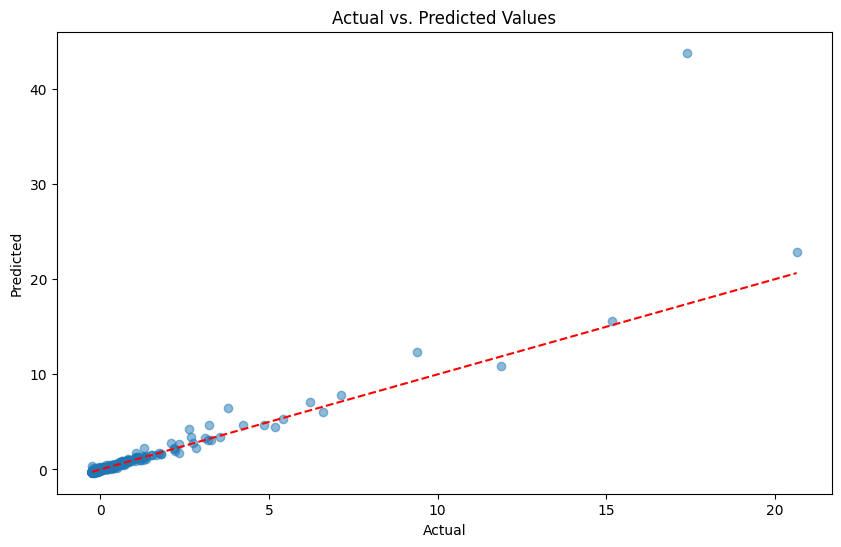

<Figure size 1000x600 with 0 Axes>

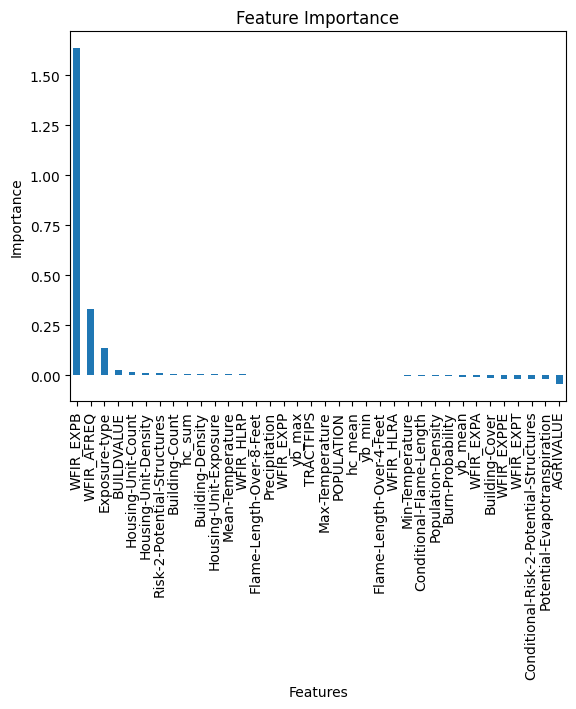

In [2]:
import pandas as pd
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# Path to the CSV file (CHANGE FILE PATH)
csv_file = 'datasets/processed/scaled_results.csv'

# Read the CSV file
df = pd.read_csv(csv_file)

# Assume 'target_var' is the dependent variable and the rest are predictors
target_var = 'WFIR_EALB'  

# Ensure the target variable is in the DataFrame
if target_var not in df.columns:
    raise ValueError(f"Target variable '{target_var}' not found in the DataFrame columns.")

# Convert categorical variables to dummy variables (one-hot encoding)
df_dummies = pd.get_dummies(df, drop_first=True)

# Drop columns with all missing values
df_dummies = df_dummies.dropna(axis=1, how='all')

# Separate dependent (target) and independent (predictor) variables
y = df_dummies[target_var]
X = df_dummies.drop(columns=[target_var])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Define the parameter distribution
param_dist = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (150,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': uniform(0.0001, 0.05),
    'learning_rate': ['constant','adaptive'],
    'max_iter': randint(200, 600)
}

# Initialize the MLP Regressor
mlp_regressor = MLPRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=mlp_regressor, param_distributions=param_dist, n_iter=100, n_jobs=-1, cv=5, scoring='r2', random_state=42, verbose=2)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Fit the model with the best parameters on the entire training data
best_mlp_regressor = random_search.best_estimator_
best_mlp_regressor.fit(X_train, y_train)

# Save the best model
#joblib.dump(best_mlp_regressor, 'best_mlp_regressor_model.joblib')

# Predict on the test data
y_pred = best_mlp_regressor.predict(X_test)

# Save the results to a CSV file
#results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#results.to_csv('best_mlp_predictions.csv', index=False)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

# Permutation feature importance
perm_importance = permutation_importance(best_mlp_regressor, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame(perm_importance.importances_mean, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', legend=False)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()